# Pratical Session : Stochastic Bandits

Code adapted from https://github.com/yfletberliac/rlss-2019 (Practical Sessions of RLSS 2019: Bandits, RL & Deep RL. https://rlss.inria.fr/program/)

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0,'Utils')

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import time
from scipy.optimize import linprog


# Bandit specific functions and classes 
import Utils.Arms as arm
from Utils.StochasticBandit import *
from Utils.StochasticBandit import MAB_NON_S
from Utils.BanditTools import * 
import Utils.BanditAlgo as alg

### Lets test the non stationary bandit class

In [7]:
nbArms = 3
ts = [3,7,10]
bandit = MAB_NON_S(k = nbArms, TS=ts, seed=42)

print("The means of bandit instance are", bandit.means)

The means of bandit instance are [0.37454012 0.95071431 0.73199394]


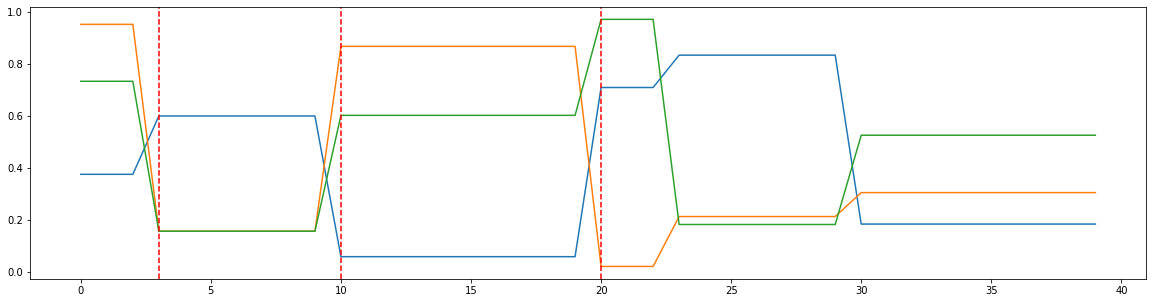

In [8]:
bandit.restore()
means = []
for _ in range(sum(ts)*2):
    means.append(bandit.means)
    bandit.generateReward(0)
plt.figure(figsize=(20,5))
plt.plot(means)

# vertical bars for TS
for i in range(len(ts)):
    plt.axvline(x=sum(ts[:i+1]), color='r', linestyle='--')
plt.show()

scheduler uses TS to schedule when distribution should be changed

#### Executing strategy

The function given below executes one bandit algorithm on one MAB instance. 

In [10]:
def OneBanditOneLearnerOneRun(bandit, learner, timeHorizon):
    """
    Run a bandit strategy (learner) on a MAB instance (bandit) for (timeHorizon) time steps
    output : sequence of arms chosen, sequence of rewards obtained
    """
    bandit.restore()
    selections = []
    rewards = []
    learner.clear() # reset previous history
    for t in range(timeHorizon):
        arm = learner.chooseArmToPlay()
        reward = bandit.generateReward(arm)
        learner.receiveReward(arm, reward)
        # Update statistics
        selections.append(arm)
        rewards.append(reward)
    return selections, rewards, bandit

In [18]:
def OneBanditOneLearnerMultipleRuns(bandit, learner, timeHorizon, N_exp, tsave=[]):
    if (len(tsave) == 0):
        tsave = np.arange(timeHorizon)
    savedTimes = len(tsave)
    Regret = np.zeros((N_exp, savedTimes)) # Store the regret values on different runs
    for n in range(N_exp):
        np.random.seed()
        _, _, bandit = OneBanditOneLearnerOneRun(bandit, learner, timeHorizon)
        regret_one_run = bandit.cumulativeRegret()
        Regret[n, :] = np.array(regret_one_run)[tsave] # Store a sub-sampling of the cumulative regret
    return Regret

For UCB : $ \delta_t=t^{-2}(t+1)^{-1}$

In [58]:
timeHorizon = 100000
# nbArms = 7
# bandit = GaussianBandit([-1, 0, 1, 2, 3, 3, 2]) # directly creates a Gaussian bandit from a vector of means
# bandit = GaussianBandit([-1, 0, 1]) # directly creates a Gaussian bandit from a vector of means
tsave = np.arange(1, timeHorizon, 5)
N_exp = 5
nbArms = 5
ts = [10000]
bandit = MAB_NON_S(k = nbArms, TS=ts, seed=41)

# UCBlearner = alg.UCB(nbArms, delta = lambda t : t **(-2) * ( t+1 )**(-1))
# _, _, UCBbandit = OneBanditOneLearnerOneRun(bandit, UCBlearner, timeHorizon) # I gived the same bandits, but they are restored at the beggining
# UCBregret = UCBbandit.cumulativeRegret()
UCBlearner = alg.UCB(nbArms, delta = lambda t : t **(-2) * ( t+1 )**(-1))
UCBregret = OneBanditOneLearnerMultipleRuns(bandit, UCBlearner, timeHorizon, N_exp, tsave = tsave)

SW_UCBlearner = alg.SW_UCB(nbArms, delta = lambda t : t **(-2) * ( t+1 )**(-1), buffer_size=10000)
SW_UCBregret = OneBanditOneLearnerMultipleRuns(bandit, SW_UCBlearner, timeHorizon, N_exp, tsave = tsave)

FTLlearner = alg.FTL(nbArms)
FTLregret = OneBanditOneLearnerMultipleRuns(bandit, FTLlearner, timeHorizon, N_exp, tsave = tsave)

/mnt/c/Users/Mustapha/Documents/CENTRALESUPELEC_3A/RL/TD/project/Utils/BanditAlgo.py:110: RuntimeWarning: invalid value encountered in double_scalars
  self.means[arm] = self.cumRewards[arm] / self.nbDraws[arm]


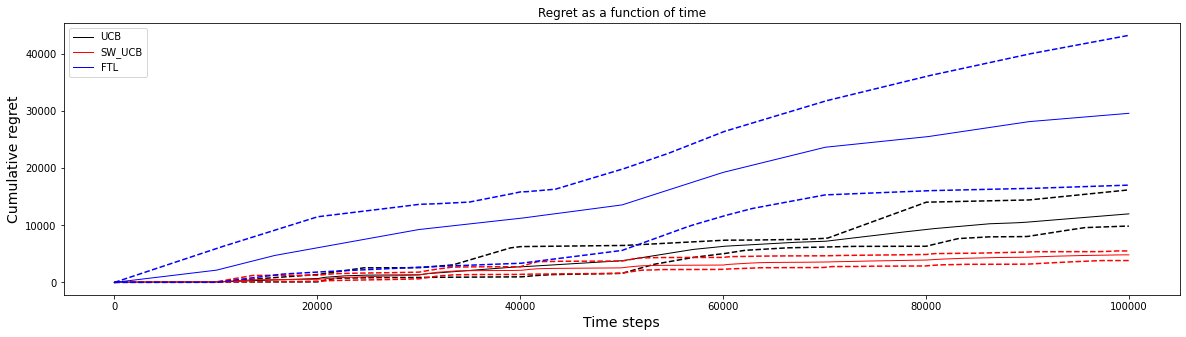

In [59]:
# Visualize results (on one run) 

# Histogram of the number of arms selections
# plt.figure(figsize=(20,5))
# plt.clf()
# plt.xlabel("Arms", fontsize=14)
# plt.ylabel("Number of arms selections", fontsize=14)
# plt.hist(selections, max(selections) + 1)
# plt.title("Number of selections of each arm", fontsize=14)
# plt.savefig('./Figure/test'+ learner.name() + '.pdf')

# Cumulative regret as a function of time
plt.figure(2, figsize=(20,5))
plt.clf()
plt.xlabel("Time steps", fontsize=14)
plt.ylabel("Cumulative regret", fontsize=14)
plt.title("Regret as a function of time")


plt.plot(tsave, np.mean(UCBregret, axis=0), 'black', linewidth=1, label=UCBlearner.name())
plt.plot(tsave, np.quantile(UCBregret, 0.95, 0), tsave, np.quantile(UCBregret,0.05,0), linestyle="dashed", color="black")

plt.plot(tsave, np.mean(SW_UCBregret, axis=0), 'r', linewidth=1, label=SW_UCBlearner.name())
plt.plot(tsave, np.quantile(SW_UCBregret, 0.95, 0), tsave, np.quantile(SW_UCBregret,0.05,0), linestyle="dashed", color="r")

plt.plot(tsave, np.mean(FTLregret, axis=0), 'b', linewidth=1, label=FTLlearner.name())
plt.plot(tsave, np.quantile(FTLregret, 0.95, 0), tsave, np.quantile(FTLregret,0.05,0), linestyle="dashed", color="b")
plt.legend()
plt.show()

# plt.figure(figsize=(20,5))
# plt.plot(bandit.historical_means)
# plt.legend(['bandit ' + str(i+1) for i in range(nbArms)])
# plt.xlabel("Time steps", fontsize=14)
# plt.ylabel("Bandit means", fontsize=14)
# plt.show()